In [13]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from transformers import PatchTSTConfig, PatchTSTForPrediction
import torch.optim as optim

## 데이터 로드

Read IBM stock OHLC ( open, high, low, close) and S&P 500 bid/ask df. df into pandas dfframe.

In [132]:
stock=pd.read_csv('삼성전자주가(20220406-20240405).csv')
df=stock.copy()

In [133]:
class Mymodel(nn.Module):
    def __init__(self, model):
        super(Mymodel, self).__init__()
        self.patch_tst = model
        self.fc=nn.Linear(model.config.num_input_channels, 1)
        # 가정: PatchTSTForPrediction의 출력 차원이 config.output_dim으로 주어짐

    def forward(self, x):
        # PatchTST 모델을 통과시킨 후의 출력
        x = self.patch_tst(past_values=x).prediction_outputs
        # 완전연결 계층을 통과시켜 최종 출력을 얻음
        x = self.fc(x)
        return x

In [172]:
class Stock:
    def __init__(self, df):
        super(Stock, self).__init__()
        self.df=df.copy()
        self.scaler_all = MinMaxScaler(feature_range=(0,1))
        self.scaler_target = MinMaxScaler(feature_range=(0,1))
        self.data=df.values
        self.predictions = []  # 예측값을 저장할 리스트
        self.actuals = []  # 실제값을 저장할 리스트
        self.train_losses = []
        self.val_losses = []

    def preprocessing(self):
        # index를 날짜로 설정
        self.df["Datetime"] = pd.to_datetime(self.df["Datetime"]).dt.strftime('%Y-%m-%d %H:%M:%S')
        self.df['Datetime'] = pd.to_datetime(self.df['Datetime'])
        self.df.set_index('Datetime', inplace=True)        
        self.df.drop('Adj Close', axis=1, inplace=True)
        return self.df

    def add_change(self, columns):
        for col in columns:
            self.df[f'{col}_chg']=self.df[col].pct_change()
        self.df.dropna(inplace=True)
        return self.df

    
    def add_col(self):
        self.df['O-C'] = self.df['Open'] - self.df['Close']
        self.df['H-L'] = self.df['High'] - self.df['Low']
        self.df['2Hr_MA'] = self.df['Close'].rolling(window=2).mean()
        self.df['4Hr_MA'] = self.df['Close'].rolling(window=4).mean()
        self.df['6Hr_MA'] = self.df['Close'].rolling(window=6).mean()
        self.df['12Hr_MA'] = self.df['Close'].rolling(window=12).mean()
        self.df['18Hr_MA'] = self.df['Close'].rolling(window=18).mean() 
        self.df['6Hr_MA'] = self.df['Close'].rolling(window=6).mean() 
        self.df['2Hr_Std'] = self.df['Close'].rolling(window = 4).std()
        self.df.dropna(inplace=True)
        return self.df

    def scale_col(self, selected_feature):
        self.selected_feature=selected_feature
        data=self.df[selected_feature].values
        self.data = self.scaler_all.fit_transform(data)
        self.scaler_target.fit_transform(data[:,0].reshape(1,-1))
        self.scaler_target.min_, self.scaler_target.scale_ = self.scaler_all.min_[0], self.scaler_all.scale_[0]


    def create_sequences(self, data, seq_length):
        xs, ys = [], []
        for i in range(len(data)-seq_length):
            x = data[i:(i+seq_length), ]
            y = data[i+seq_length, 0]  # 예측하려는 값을 0에 배치
            xs.append(x)
            ys.append(y)
        return np.array(xs), np.array(ys)
    
    def data_loader(self, seq_len, type='train'):
        self.seq_len=seq_len
        train_size = int(len(self.data) * 0.7)
        val_size = int(len(self.data) * 0.2)
        test_size = len(self.data) - train_size - val_size

        if type=='train':
            X, y = self.create_sequences(self.data[:train_size], seq_len)
        elif type=='valid':
            X, y = self.create_sequences(self.data[train_size:train_size+val_size], seq_len)
        elif type=='test':
            X, y = self.create_sequences(self.data[train_size+val_size:], seq_len)
        else:
            X, y = self.create_sequences(self.data, seq_len)
                
        X = torch.tensor(X, dtype=torch.float32)
        y = torch.tensor(y, dtype=torch.float32)

        data = TensorDataset(X, y)
        data_loader = DataLoader(dataset=data, batch_size=16, shuffle=False)

        return data_loader
    
    def create_model(self, pred_length=1, d=0.3):
        configuration = PatchTSTConfig(prediction_length=pred_length, context_length=self.seq_len, num_input_channels=len(self.selected_feature), drop_out=d)
        self.patch = PatchTSTForPrediction(configuration)
        self.fc = nn.Linear(self.patch.config.num_input_channels, 1)
        self.model=Mymodel(self.patch) # 모델 정의
    
    def train(self, train_loader, val_loader, test_loader, patience, lr, epoch, type, min_delta=0.00001):
        self.patience = patience  # 검증 손실이 개선되지 않는 에포크 허용 횟수
        self.min_delta = min_delta  # 개선으로 간주되기 위한 최소 변화량
        best_loss = np.inf  # 가장 낮은 검증 손실을 추적
        last_val_loss = np.inf
        patience_counter = 0  # 개선되지 않는 에포크를 세는 카운터

        # 손실 함수와 최적화 알고리즘 설정
        criterion = nn.MSELoss()
        optimizer = optim.Adam(self.model.parameters(), lr=lr)

        # 학습 과정
        epochs = epoch
        k=0.5
        if type=='train':
            for epoch in range(epochs):
                self.model.train()  # 모델을 훈련 모드로 설정
                train_loss = 0.0

                for seqs, labels in train_loader:
                    optimizer.zero_grad()  # 그래디언트 초기화
                    outputs = self.model.forward(seqs)
                    loss = criterion(outputs, labels)
                    loss.backward()
                    optimizer.step()  # 최적화 알고리즘을 통한 파라미터 업데이트
                    
                    train_loss += loss.item() * seqs.size(0)
                
                train_loss /= len(train_loader.dataset)
                self.train_losses.append(train_loss)

                self.model.eval()  # 모델을 평가 모드로 설정
                val_loss = 0.0

                with torch.no_grad():
                    self.model.eval()
                    for seqs, labels in val_loader:
                        outputs = self.model.forward(seqs)
                        loss = criterion(outputs, labels)
                        val_loss += loss.item() * seqs.size(0)  # 누적 손실 계산

                # 에포크별 평균 검증 손실 계산
                val_loss /= len(val_loader.dataset)
                self.val_losses.append(val_loss)

                print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.5f}, Val Loss: {val_loss:.5f}')

                if train_loss*1.4 < val_loss - min_delta:
                    best_loss = val_loss
                    patience_counter = 0
                else:
                    patience_counter += 1
                    print(f'Learning rate {patience_counter} of {patience}')

                last_val_loss = val_loss  # 마지막 검증 손실 업데이트

                if patience_counter >= patience:
                    print(f'Learning rate: {0.001*k}')
                    optimizer = optim.Adam(self.model.parameters(), lr=0.001*k)
                    k*=0.5
                    patience_counter=0

            print(f'best loss: {best_loss}')

        if type=='test':
            self.predictions=[]
            self.actuals=[]
            self.model.eval()  # 모델을 평가 모드로 설정
            test_losses = []  # 테스트 손실을 저장할 리스트

            with torch.no_grad():  # 기울기 계산을 비활성화
                for seqs, labels in test_loader:

                    outputs = self.model(seqs)

                    # 손실 계산
                    loss = criterion(outputs, labels)
                    test_losses.append(loss.item())

                    # 예측값과 실제값 저장
                    self.predictions.extend(outputs.view(-1).detach().numpy())
                    self.actuals.extend(labels.view(-1).detach().numpy())

            # 평균 테스트 손실 계산 및 출력
            average_test_loss = sum(test_losses) / len(test_losses)
            print(f'Average Test Loss: {average_test_loss}')

    def pred_value(self):
        self.predictions_inverse = np.round(self.scaler_target.inverse_transform(np.array(self.predictions).reshape(-1,1)), -2)
        self.actuals_inverse = np.round(self.scaler_target.inverse_transform(np.array(self.actuals).reshape(-1,1)), -2)
        return self.predictions_inverse, self.actuals_inverse
    
    def diff(self):
        differences = [abs(pred - actual) for pred, actual in zip(self.predictions_inverse, self.actuals_inverse)]
        print("최대 : " , max(differences) ,"최소 : " , min(differences) ,"평균: " , sum(differences) / len(differences))

    def loss(self):
        # 훈련 손실과 검증 손실을 에포크별로 그래프로 그리기
        plt.figure(figsize=(10, 6))  # 그래프 크기 설정
        plt.plot(self.train_losses, label='Training Loss', marker='o')  # 훈련 손실 그래프
        plt.plot(self.val_losses, label='Validation Loss', marker='x')  # 검증 손실 그래프
        plt.title('Training and Validation Loss')  # 그래프 제목
        plt.xlabel('Epochs')  # x축 라벨
        plt.ylabel('Loss')  # y축 라벨
        plt.legend()  # 범례 표시
        plt.grid(True)  # 그리드 표시
        plt.show()  # 그래프 보여주기
    
    
    def show(self, type):
        if type=='chg':
            predictions_inverse=self.predictions_inverse[1:]
            actuals_inverse=self.actuals_inverse[1:]

        else:
            predictions_inverse=self.predictions_inverse
            actuals_inverse=self.actuals_inverse

        n = 60
        num_plots = len(predictions_inverse) // n
        if len(predictions_inverse) % n != 0:
            num_plots += 1

        # Plot 생성
        fig, axes = plt.subplots(num_plots, 1, figsize=(10, 6*num_plots))

        for i in range(num_plots):
            start_index = i * n
            end_index = min((i + 1) * n, len(predictions_inverse))
            
            # Subplot 생성
            ax = axes[i] if num_plots > 1 else axes
            
            # 예측값과 실제값 그리기
            ax.plot(predictions_inverse[start_index:end_index], label='Predictions')
            ax.plot(actuals_inverse[start_index:end_index], label='Actuals')
            ax.set_title(f'Predictions vs Actuals (Subset {i+1})')
            ax.set_xlabel('Index')
            ax.set_ylabel('Values')
            ax.legend()
            ax.grid(True)

        plt.tight_layout()
        plt.show()

In [173]:
stock=Stock(df)

In [174]:
stock.preprocessing()

,Open,High,Low,Close,Volume
Datetime,,,,,
2022-04-06 09:00:00,68600.0,68800.0,68600.0,68700.0,0
2022-04-06 10:00:00,68600.0,68800.0,68600.0,68700.0,1846582
2022-04-06 11:00:00,68700.0,68700.0,68600.0,68600.0,901392
2022-04-06 12:00:00,68700.0,68700.0,68500.0,68600.0,2053045
2022-04-06 13:00:00,68600.0,68600.0,68500.0,68600.0,924688
...,...,...,...,...,...
2024-04-05 10:00:00,84700.0,84800.0,83800.0,84000.0,3548675
2024-04-05 11:00:00,83900.0,84300.0,83900.0,84200.0,1732644
2024-04-05 12:00:00,84300.0,84500.0,84100.0,84400.0,1052082


In [175]:
stock.add_change(stock.df.columns)

,Open,High,Low,Close,Volume,Open_chg,High_chg,Low_chg,Close_chg,Volume_chg
Datetime,,,,,,,,,,
2022-04-06 10:00:00,68600.0,68800.0,68600.0,68700.0,1846582,0.000000,0.000000,0.000000,0.000000,inf
2022-04-06 11:00:00,68700.0,68700.0,68600.0,68600.0,901392,0.001458,-0.001453,0.000000,-0.001456,-0.511859
2022-04-06 12:00:00,68700.0,68700.0,68500.0,68600.0,2053045,0.000000,0.000000,-0.001458,0.000000,1.277638
2022-04-06 13:00:00,68600.0,68600.0,68500.0,68600.0,924688,-0.001456,-0.001456,0.000000,0.000000,-0.549602
2022-04-06 14:00:00,68600.0,68700.0,68500.0,68500.0,2004197,0.000000,0.001458,0.000000,-0.001458,1.167431
...,...,...,...,...,...,...,...,...,...,...
2024-04-05 10:00:00,84700.0,84800.0,83800.0,84000.0,3548675,0.002367,-0.002353,0.000000,-0.008264,-0.562848
2024-04-05 11:00:00,83900.0,84300.0,83900.0,84200.0,1732644,-0.009445,-0.005896,0.001193,0.002381,-0.511749
2024-04-05 12:00:00,84300.0,84500.0,84100.0,84400.0,1052082,0.004768,0.002372,0.002384,0.002375,-0.392788


In [176]:
stock.scale_col(stock.df.columns[[3,0,1,2,4]]) # 종가
# stock.scale_col(stock.df.columns[[8,5,6,7,9]]) # 종가(변화율)

In [177]:
train_loader=stock.data_loader(4, 'train')

In [178]:
valid_loader=stock.data_loader(4, 'valid')

In [179]:
test_loader=stock.data_loader(4, 'test')

In [196]:
stock.create_model(1, 0.2)

In [197]:
stock.train(train_loader, valid_loader, test_loader, 5, 0.001, 10, 'train')

Epoch 1/10, Train Loss: 0.04326, Val Loss: 0.07112
Epoch 2/10, Train Loss: 0.01536, Val Loss: 0.03584
Epoch 3/10, Train Loss: 0.00650, Val Loss: 0.00651
Learning rate 1 of 5
Epoch 4/10, Train Loss: 0.00306, Val Loss: 0.00235
Learning rate 2 of 5
Epoch 5/10, Train Loss: 0.00301, Val Loss: 0.00164
Learning rate 3 of 5
Epoch 6/10, Train Loss: 0.00234, Val Loss: 0.00127
Learning rate 4 of 5
Epoch 7/10, Train Loss: 0.00184, Val Loss: 0.00106
Learning rate 5 of 5
Learning rate: 0.0005
Epoch 8/10, Train Loss: 0.00103, Val Loss: 0.00096
Learning rate 1 of 5
Epoch 9/10, Train Loss: 0.00094, Val Loss: 0.00101
Learning rate 2 of 5
Epoch 10/10, Train Loss: 0.00094, Val Loss: 0.00103
Learning rate 3 of 5
best loss: 0.035842054886854484


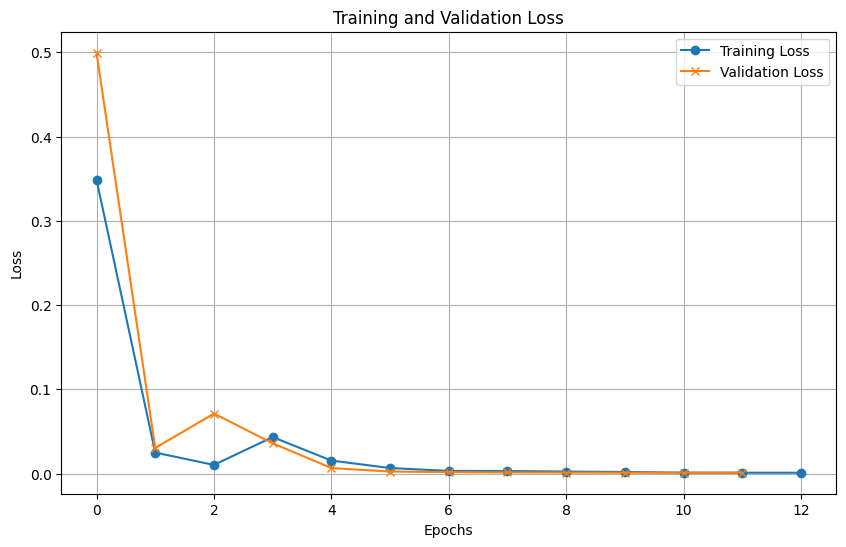

In [198]:
stock.loss()

In [203]:
stock.train(train_loader, valid_loader, test_loader, 7, 0.001, 80, 'test')

Average Test Loss: 0.0015453313489591604


c:\Users\horri\anaconda3\envs\pytorch\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\horri\anaconda3\envs\pytorch\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([5])) that is different to the input size (torch.Size([5, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


In [204]:
pred, act=stock.pred_value()

In [205]:
stock.diff()

최대 :  [3300.] 최소 :  [0.] 평균:  [638.5665]


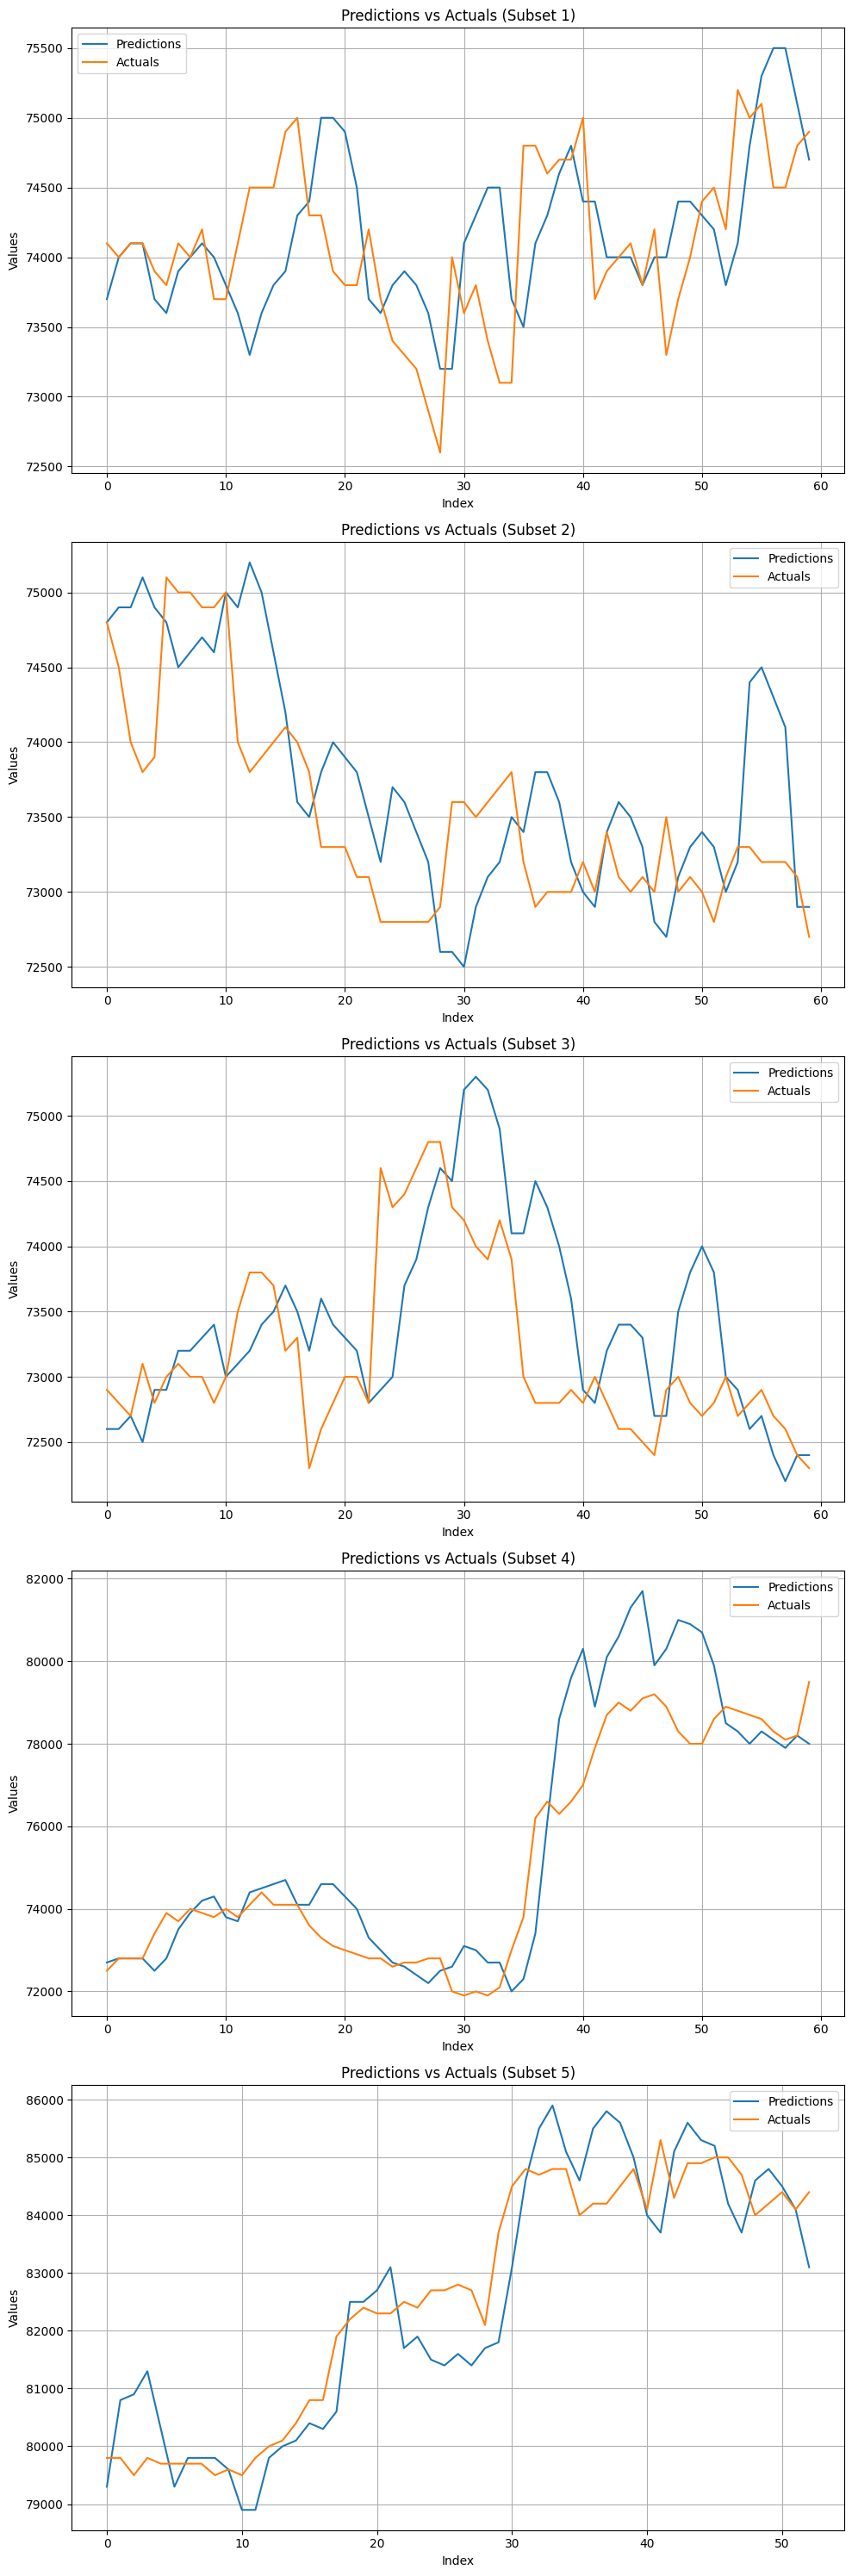

In [206]:
stock.show('origin')

In [73]:
'''
import itertools

# 실험할 하이퍼파라미터 조합 정의
learning_rates = [0.001, 0.01, 0.1]
batch_sizes = [16, 32, 64]
hidden_sizes = [64, 128, 256]
seq_len = [6, 12, 24, 48]
drop_out=[0.1, 0.2, 0.5]

# 가능한 모든 하이퍼파라미터 조합 생성
hyperparameter_combinations = list(itertools.product(learning_rates, batch_sizes, hidden_sizes, seq_len))

best_val_loss = np.inf
best_hyperparameters = None

# 각 하이퍼파라미터 조합에 대해 그리드 서치 실행
for lr, batch_size, hidden_size, seq_len in hyperparameter_combinations:

    # DataLoader 설정
    train_data = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=False)

    val_data = TensorDataset(X_val_tensor, y_val_tensor)
    val_loader = DataLoader(dataset=val_data, batch_size=batch_size, shuffle=False)

    # 모델 설정 변경
    # 일단은 통합적으로 생성
    class configs:
        seq_len = seq_len
        pred_len = 1
        enc_in = 6  # 입력 채널을 5로 변경 (시가, 고가, 저가, 종가, 거래량)
        individual = False
    
    # 모델 생성
    configuration = PatchTSTConfig(prediction_length=1, context_length=seq_len, num_input_channels=6, drop_out=drop_out, hidden_size=hidden_size)

    model = PatchTSTForPrediction(configuration)
    
    # 모델 학습 및 검증
    patience = 25  # 검증 손실이 개선되지 않는 에포크 허용 횟수
    min_delta = 0.00001  # 개선으로 간주되기 위한 최소 변화량
    best_loss = np.inf  # 가장 낮은 검증 손실을 추적dd
    last_val_loss = np.inf
    patience_counter = 0  # 개선되지 않는 에포크를 세는 카운터

    # 손실 함수와 최적화 알고리즘 설정
    criterion = RMSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)



    # 학습 과정
    epochs = 100

    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        model.train()  # 모델을 훈련 모드로 설정
        train_loss = 0.0

        for seqs, labels in train_loader:
            optimizer.zero_grad()  # 그래디언트 초기화
            outputs = model(
                past_values=seqs
            )
            loss = criterion(outputs.prediction_outputs[:,:,3], labels)
            loss.backward()
            optimizer.step()  # 최적화 알고리즘을 통한 파라미터 업데이트

            train_loss += loss.item() * seqs.size(0)

        train_loss /= len(train_loader.dataset)
        train_losses.append(train_loss)

        model.eval()  # 모델을 평가 모드로 설정
        val_loss = 0.0

        with torch.no_grad():
            model.eval()
            for seqs, labels in val_loader:
                outputs = model(
                    past_values=seqs
                )
                loss = criterion(outputs.prediction_outputs[:,:,3], labels)
                val_loss += loss.item() * seqs.size(0)  # 누적 손실 계산

        # 에포크별 평균 검증 손실 계산
        val_loss /= len(val_loader.dataset)
        val_losses.append(val_loss)

        print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.5f}, Val Loss: {val_loss:.5f}')

        if val_loss < best_loss - min_delta:
            best_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1
            print(f'Early Stopping Counter {patience_counter} of {patience}')

        last_val_loss = val_loss  # 마지막 검증 손실 업데이트

        if patience_counter >= patience:
            print("Early stopping initiated.")
            print(f"Best Validation Loss: {best_loss:.5f}")
            break
    
    # 검증 성능 평가
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_hyperparameters = (lr, batch_size, hidden_size)

print("Best Validation Loss:", best_val_loss)
print("Best Hyperparameters:", best_hyperparameters)
'''

'\nimport itertools\n\n# 실험할 하이퍼파라미터 조합 정의\nlearning_rates = [0.001, 0.01, 0.1]\nbatch_sizes = [16, 32, 64]\nhidden_sizes = [64, 128, 256]\nseq_len = [6, 12, 24, 48]\ndrop_out=[0.1, 0.2, 0.5]\n\n# 가능한 모든 하이퍼파라미터 조합 생성\nhyperparameter_combinations = list(itertools.product(learning_rates, batch_sizes, hidden_sizes, seq_len))\n\nbest_val_loss = np.inf\nbest_hyperparameters = None\n\n# 각 하이퍼파라미터 조합에 대해 그리드 서치 실행\nfor lr, batch_size, hidden_size, seq_len in hyperparameter_combinations:\n\n    # DataLoader 설정\n    train_data = TensorDataset(X_train_tensor, y_train_tensor)\n    train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=False)\n\n    val_data = TensorDataset(X_val_tensor, y_val_tensor)\n    val_loader = DataLoader(dataset=val_data, batch_size=batch_size, shuffle=False)\n\n    # 모델 설정 변경\n    # 일단은 통합적으로 생성\n    class configs:\n        seq_len = seq_len\n        pred_len = 1\n        enc_in = 6  # 입력 채널을 5로 변경 (시가, 고가, 저가, 종가, 거래량)\n        individual = False\

In [207]:
torch.save(stock.model.state_dict(), 'close.pth')
#torch.save(stock.model.state_dict(), 'chg_close.pth')

수익률계산

In [289]:
df_get=pd.read_csv('수익률 계산.csv')

In [290]:
df_get

,Datetime,Open,High,Low,Close,Adj Close,Volume
0,2024-04-22 09:00:00+09:00,77400.0,77400.0,77200.0,77300.0,77300.0,0
1,2024-04-22 09:01:00+09:00,77300.0,77400.0,77100.0,77200.0,77200.0,337409
2,2024-04-22 09:02:00+09:00,77100.0,77200.0,77000.0,77100.0,77100.0,267021
3,2024-04-22 09:03:00+09:00,77000.0,77200.0,77000.0,77100.0,77100.0,218955
4,2024-04-22 09:04:00+09:00,77100.0,77100.0,76800.0,76800.0,76800.0,284661
...,...,...,...,...,...,...,...
1793,2024-04-26 14:54:00+09:00,76800.0,76800.0,76700.0,76700.0,76700.0,8382
1794,2024-04-26 14:55:00+09:00,76800.0,76800.0,76700.0,76800.0,76800.0,15591
1795,2024-04-26 14:57:00+09:00,76800.0,76800.0,76700.0,76800.0,76800.0,22806
1796,2024-04-26 14:58:00+09:00,76700.0,76800.0,76700.0,76800.0,76800.0,16832


In [291]:
df_get=pd.concat([df_get.iloc[:210], pd.DataFrame([df_get.iloc[210]]), df_get.iloc[210:]]).reset_index(drop=True)
df_get=pd.concat([df_get.iloc[:1795], pd.DataFrame([df_get.iloc[1795]]), df_get.iloc[1795:]]).reset_index(drop=True)

In [234]:
df_pred=df_get.iloc[::60,:]

모델 학습

In [236]:
stock.df=df_pred.copy()

In [237]:
stock.preprocessing()

,Open,High,Low,Close,Volume
Datetime,,,,,
2024-04-22 09:00:00,77400.0,77400.0,77200.0,77300.0,0
2024-04-22 10:00:00,76400.0,76400.0,76200.0,76300.0,271051
2024-04-22 11:00:00,76200.0,76200.0,76100.0,76200.0,30577
2024-04-22 12:00:00,75700.0,75800.0,75700.0,75800.0,20634
2024-04-22 13:00:00,75700.0,75700.0,75600.0,75700.0,26315
2024-04-22 14:00:00,75600.0,75700.0,75600.0,75700.0,17199
2024-04-23 09:00:00,76400.0,76700.0,76300.0,76700.0,1220923
2024-04-23 10:00:00,76600.0,76600.0,76500.0,76600.0,10481
2024-04-23 11:00:00,76100.0,76200.0,76100.0,76100.0,8237


In [238]:
stock.add_change(stock.df.columns)

,Open,High,Low,Close,Volume,Open_chg,High_chg,Low_chg,Close_chg,Volume_chg
Datetime,,,,,,,,,,
2024-04-22 10:00:00,76400.0,76400.0,76200.0,76300.0,271051,-0.012920,-0.012920,-0.012953,-0.012937,inf
2024-04-22 11:00:00,76200.0,76200.0,76100.0,76200.0,30577,-0.002618,-0.002618,-0.001312,-0.001311,-0.887191
2024-04-22 12:00:00,75700.0,75800.0,75700.0,75800.0,20634,-0.006562,-0.005249,-0.005256,-0.005249,-0.325179
2024-04-22 13:00:00,75700.0,75700.0,75600.0,75700.0,26315,0.000000,-0.001319,-0.001321,-0.001319,0.275322
2024-04-22 14:00:00,75600.0,75700.0,75600.0,75700.0,17199,-0.001321,0.000000,0.000000,0.000000,-0.346418
2024-04-23 09:00:00,76400.0,76700.0,76300.0,76700.0,1220923,0.010582,0.013210,0.009259,0.013210,69.988023
2024-04-23 10:00:00,76600.0,76600.0,76500.0,76600.0,10481,0.002618,-0.001304,0.002621,-0.001304,-0.991416
2024-04-23 11:00:00,76100.0,76200.0,76100.0,76100.0,8237,-0.006527,-0.005222,-0.005229,-0.006527,-0.214102
2024-04-23 12:00:00,76100.0,76100.0,76000.0,76100.0,6358,0.000000,-0.001312,-0.001314,0.000000,-0.228117


In [239]:
stock.scale_col(stock.df.columns[[3,0,1,2,4]])

In [253]:
test_loader=stock.data_loader(4, 't')

In [254]:
stock.model.load_state_dict(torch.load('close.pth'))

<All keys matched successfully>

In [255]:
stock.train(train_loader, valid_loader, test_loader, 7, 0.001, 80, 'test')

Average Test Loss: 0.104620979167521


c:\Users\horri\anaconda3\envs\pytorch\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\horri\anaconda3\envs\pytorch\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([9])) that is different to the input size (torch.Size([9, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


In [256]:
pred, act=stock.pred_value()

In [257]:
stock.diff()

최대 :  [1500.] 최소 :  [0.] 평균:  [616.]


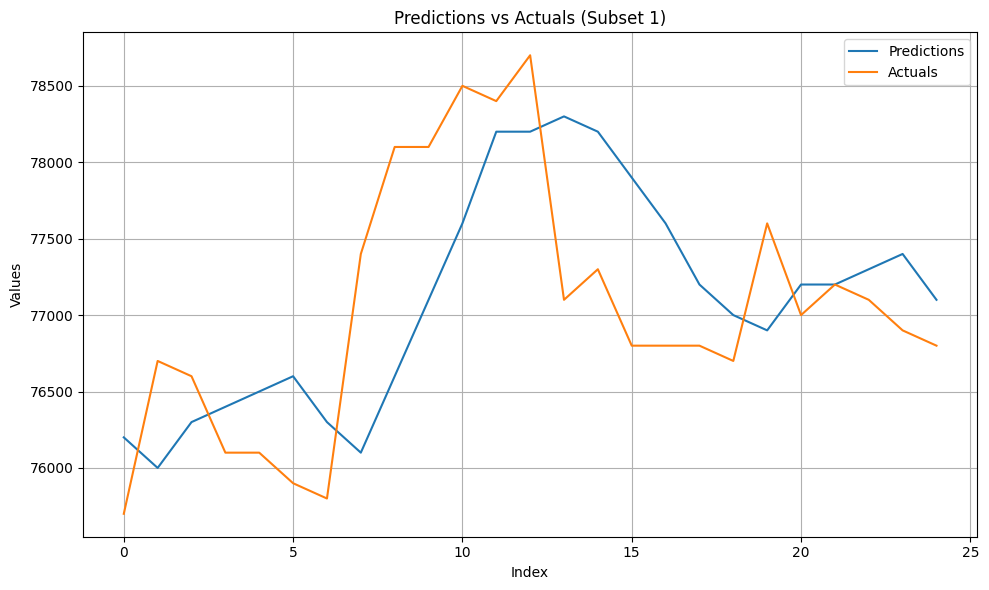

In [258]:
stock.show('origin')

In [293]:
df_get['4H_MA'] = df_get['Close'].rolling(window=4).mean()
df_get['8H_MA'] = df_get['Close'].rolling(window=8).mean()

In [294]:
df_get=df_get.iloc[300:,]

In [296]:
df_get['pred']=[item for item in pred for _ in range(60)]

C:\Users\horri\AppData\Local\Temp\ipykernel_18792\2763114686.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_get['pred']=[item for item in pred for _ in range(60)]


In [318]:
# 매매 신호 생성
df_get.loc[:,'Signal'] = np.where(df_get['4H_MA'] >= df_get['8H_MA'], 1, 0)
df_get.loc[:,'Signal2'] = np.where(df_get['pred']>=df_get['Open'], 1, 0)

# 수익률 계산
df_get.loc[:,'Returns'] = df_get['Close'] - df_get['Close'].shift(1)
df_get.loc[:,'Strategy'] = df_get['Signal'] * df_get['Returns'] * df_get['Signal2']
cumulative_returns = df_get['Strategy'].sum()

In [322]:
# 최종 수익률 출력
print(f"Cumulative returns: {cumulative_returns}")
print(f'Percent: {cumulative_returns/df.iloc[0,4]}')

Cumulative returns: 1400.0
Percent: 0.020378457059679767


In [323]:
buy_hold=df_get.iloc[-1, 4]-df_get.iloc[0, 4]
print(buy_hold) # buy & hold
print(f'Percent: {buy_hold/df.iloc[0,4]}')

1100.0
Percent: 0.01601164483260553
